In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PySpark") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

24/06/24 23:06:59 WARN Utils: Your hostname, nobara-ll5 resolves to a loopback address: 127.0.1.1; using 192.168.1.22 instead (on interface eno1)
24/06/24 23:06:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/24 23:07:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
print(spark)

In [3]:
import cv2
import numpy as np
import os
import sys
from pyspark.sql.functions import udf
from pyspark.sql.types import BinaryType
from pyspark.sql import Row

def read_image(name):
    image = cv2.imread(name)
    _, buffer = cv2.imencode('.jpg', image)
    return buffer.tobytes()

read_image_udf = udf(lambda z: read_image(z), BinaryType())




In [4]:
image_paths = []
paths = []
rows = []
dates = []

for data in os.listdir('data'):
    image_paths.append('data/' + data)
    paths.append(data.split('_')[2][:3])
    rows.append(data.split('_')[2][3:])
    dates.append(f'{data.split('_')[4][:4]}, {data.split("_")[4][4:6]}, {data.split("_")[4][6:]}')

df_row = [None] * len(image_paths)
for i in range(len(image_paths)):
    df_row[i] = Row(image_path=image_paths[i], path=paths[i], row=rows[i], date=dates[i])
    print(df_row[i])



Row(image_path='data/LC08_L1TP_038032_20130609_20200913_02_T1.jpg', path='038', row='032', date='2020, 09, 13')
Row(image_path='data/LC08_L1TP_038032_20230925_20231002_02_T1.jpg', path='038', row='032', date='2023, 10, 02')
Row(image_path='data/LC08_L1TP_039031_20160726_20200906_02_T1.jpg', path='039', row='031', date='2020, 09, 06')
Row(image_path='data/LC08_L1TP_160043_20130413_20200913_02_T1.jpg', path='160', row='043', date='2020, 09, 13')
Row(image_path='data/LC08_L1TP_160043_20140126_20200912_02_T1.jpg', path='160', row='043', date='2020, 09, 12')
Row(image_path='data/LC08_L1TP_160043_20231205_20231209_02_T1.jpg', path='160', row='043', date='2023, 12, 09')
Row(image_path='data/LC08_L1TP_163042_20130327_20200912_02_T1.jpg', path='163', row='042', date='2020, 09, 12')
Row(image_path='data/LC08_L1TP_163042_20240619_20240620_02_RT.jpg', path='163', row='042', date='2024, 06, 20')
Row(image_path='data/LC08_L1TP_174038_20240616_20240616_02_RT.jpg', path='174', row='038', date='2024, 0

In [5]:
import pandas as pd

df_row_data = {'image_path': [row['image_path'] for row in df_row],
               'path': [row['path'] for row in df_row],
               'row': [row['row'] for row in df_row],
               'date': [row['date'] for row in df_row]}

df_row_df = pd.DataFrame(df_row_data)
print(df_row_df)

                                           image_path path  row          date
0   data/LC08_L1TP_038032_20130609_20200913_02_T1.jpg  038  032  2020, 09, 13
1   data/LC08_L1TP_038032_20230925_20231002_02_T1.jpg  038  032  2023, 10, 02
2   data/LC08_L1TP_039031_20160726_20200906_02_T1.jpg  039  031  2020, 09, 06
3   data/LC08_L1TP_160043_20130413_20200913_02_T1.jpg  160  043  2020, 09, 13
4   data/LC08_L1TP_160043_20140126_20200912_02_T1.jpg  160  043  2020, 09, 12
5   data/LC08_L1TP_160043_20231205_20231209_02_T1.jpg  160  043  2023, 12, 09
6   data/LC08_L1TP_163042_20130327_20200912_02_T1.jpg  163  042  2020, 09, 12
7   data/LC08_L1TP_163042_20240619_20240620_02_RT.jpg  163  042  2024, 06, 20
8   data/LC08_L1TP_174038_20240616_20240616_02_RT.jpg  174  038  2024, 06, 16
9   data/LC08_L1TP_230062_20190830_20200826_02_T1.jpg  230  062  2020, 08, 26
10  data/LC08_L1TP_230062_20231028_20231101_02_T1.jpg  230  062  2023, 11, 01
11  data/LC08_L1TP_232067_20130827_20200912_02_T1.jpg  232  067 

/tmp/ipykernel_212845/3859101610.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [13]:
print(df_row_df.count())
print(len(df_row_df))

spark_df = spark.createDataFrame(df_row_df)
spark_df.show()






image_path    16
path          16
row           16
date          16
dtype: int64
16


+--------------------+----+---+------------+
|          image_path|path|row|        date|
+--------------------+----+---+------------+
|data/LC08_L1TP_03...| 038|032|2020, 09, 13|
|data/LC08_L1TP_03...| 038|032|2023, 10, 02|
|data/LC08_L1TP_03...| 039|031|2020, 09, 06|
|data/LC08_L1TP_16...| 160|043|2020, 09, 13|
|data/LC08_L1TP_16...| 160|043|2020, 09, 12|
|data/LC08_L1TP_16...| 160|043|2023, 12, 09|
|data/LC08_L1TP_16...| 163|042|2020, 09, 12|
|data/LC08_L1TP_16...| 163|042|2024, 06, 20|
|data/LC08_L1TP_17...| 174|038|2024, 06, 16|
|data/LC08_L1TP_23...| 230|062|2020, 08, 26|
|data/LC08_L1TP_23...| 230|062|2023, 11, 01|
|data/LC08_L1TP_23...| 232|067|2020, 09, 12|
|data/LC08_L1TP_23...| 232|067|2024, 06, 22|
|data/LC09_L1TP_03...| 039|031|2023, 07, 23|
|data/LC09_L1TP_16...| 160|043|2024, 06, 22|
|data/LO08_L1TP_17...| 174|038|2020, 09, 24|
+--------------------+----+---+------------+



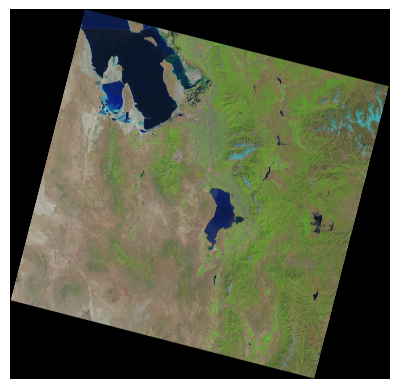

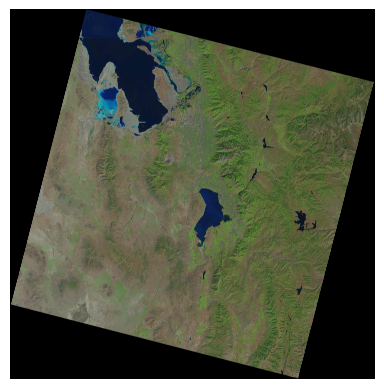

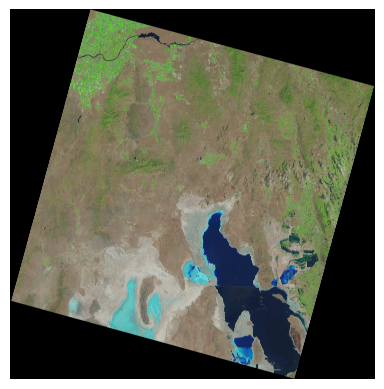

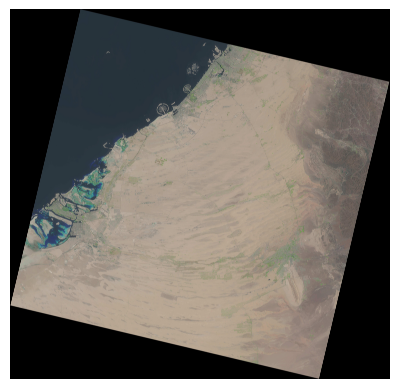

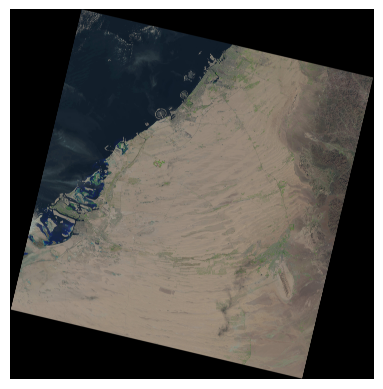

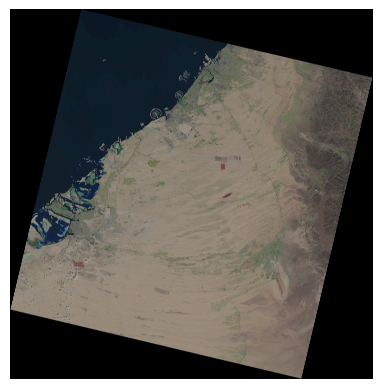

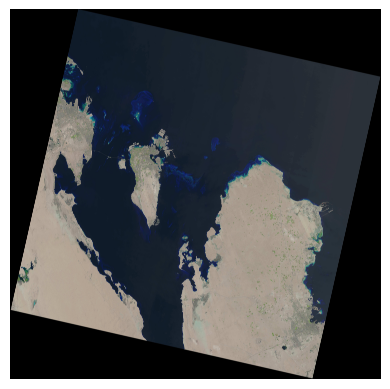

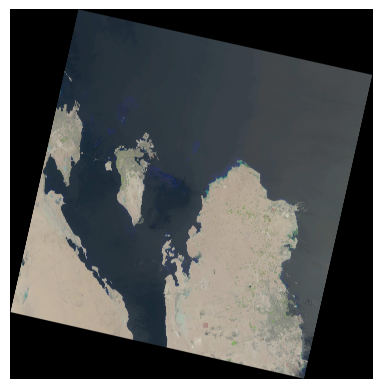

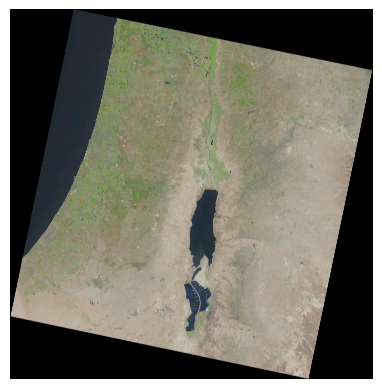

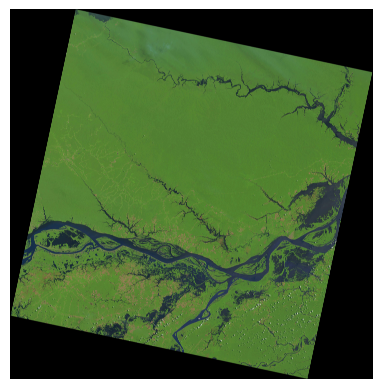

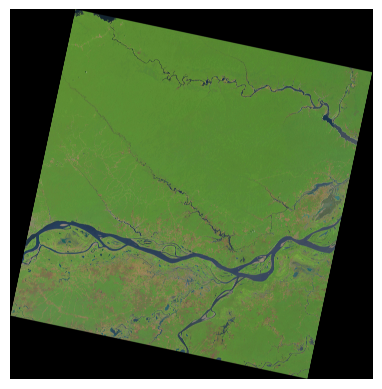

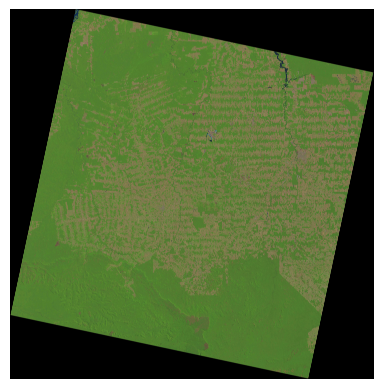

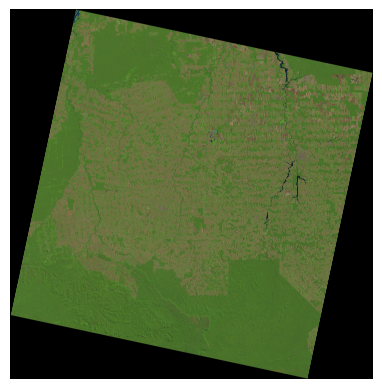

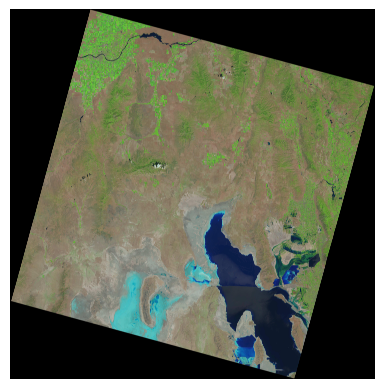

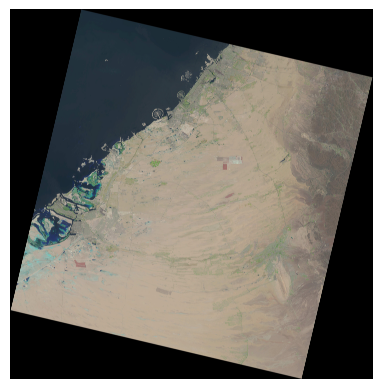

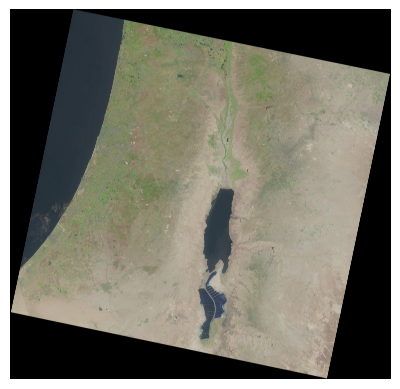

In [16]:
from PIL import Image
import io

# Function to convert image bytes to PIL Image object
def bytes_to_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    return image

# Convert the image_path column to a list
image_paths = spark_df.select("image_path").rdd.flatMap(lambda x: x).collect()

import matplotlib.pyplot as plt

# Load and display each image
for image_path in image_paths:
    image_bytes = spark.read.format("binaryFile").load(image_path).select("content").first()[0]
    image = bytes_to_image(image_bytes)
    plt.imshow(image)
    plt.axis('off')
    plt.show()